In [1]:
import torch
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import draw_neural_net
import time

start_time = time.time()

### One-hot-encoding for categorical attributes

In [2]:
# Read file and store as pandas dataframe
filename = '../Data/day.csv'
df = pd.read_csv(filename)

for attribute in ['instant','dteday','yr','mnth','holiday','weekday','casual','registered']:
    df = df.drop(attribute, axis=1)
    
# One hot encoding
ohe_df = pd.get_dummies(df, columns = ['season','weathersit'])
ohe_df = ohe_df.drop(['season_4','weathersit_3'], axis=1)    # season_4, weathersit_3 are chosen as reference variables
display(ohe_df)

,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,weathersit_1,weathersit_2
0,0,0.344167,0.363625,0.805833,0.160446,985,1,0,0,0,1
1,0,0.363478,0.353739,0.696087,0.248539,801,1,0,0,0,1
2,1,0.196364,0.189405,0.437273,0.248309,1349,1,0,0,1,0
3,1,0.200000,0.212122,0.590435,0.160296,1562,1,0,0,1,0
4,1,0.226957,0.229270,0.436957,0.186900,1600,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
726,1,0.254167,0.226642,0.652917,0.350133,2114,1,0,0,0,1
727,1,0.253333,0.255046,0.590000,0.155471,3095,1,0,0,0,1
728,0,0.253333,0.242400,0.752917,0.124383,1341,1,0,0,0,1
729,0,0.255833,0.231700,0.483333,0.350754,1796,1,0,0,1,0


### Standardize data

In [3]:
N, M = ohe_df.shape
attribute_names = list(ohe_df.columns)

# Get column indexes
temp_col = ohe_df.columns.get_loc("temp")
atemp_col = ohe_df.columns.get_loc("atemp")
hum_col = ohe_df.columns.get_loc("hum")
wspd_col = ohe_df.columns.get_loc("windspeed")
cnt_col = ohe_df.columns.get_loc("cnt")

# Undo the original max-min normalization
data = ohe_df.values
for row in range(0, N):
    data[row, temp_col] = data[row, temp_col]*(39-(-8)) + (-8)
    data[row, atemp_col] = data[row, atemp_col]*(50-(-16)) + (-16)
    data[row, hum_col] = data[row, hum_col]*100
    data[row, wspd_col] = data[row, wspd_col]*67

# Standarize ratio data attributes
for col in range(temp_col, cnt_col+1): # subtract mean column-wise
    mn = data[:, col].mean(0)
    std = np.std(data[:, col])
    data[:, col] = (data[:, col] - np.ones(N)*mn)/std

# Create DataFrame for visualisation
data_df = pd.DataFrame(data, columns=attribute_names)
display(data_df)

,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,weathersit_1,weathersit_2
0,0.0,-0.826662,-0.679946,1.250171,-0.387892,-1.817953,1.0,0.0,0.0,0.0,1.0
1,0.0,-0.721095,-0.740652,0.479113,0.749602,-1.912999,1.0,0.0,0.0,0.0,1.0
2,1.0,-1.634657,-1.749767,-1.339274,0.746632,-1.629925,1.0,0.0,0.0,1.0,0.0
3,1.0,-1.614780,-1.610270,-0.263182,-0.389829,-1.519898,1.0,0.0,0.0,1.0,0.0
4,1.0,-1.467414,-1.504971,-1.341494,-0.046307,-1.500269,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,-1.318665,-1.521108,0.175807,2.061426,-1.234757,1.0,0.0,0.0,0.0,1.0
727,1.0,-1.323224,-1.346690,-0.266238,-0.452131,-0.728012,1.0,0.0,0.0,0.0,1.0
728,0.0,-1.323224,-1.424344,0.878392,-0.853552,-1.634057,1.0,0.0,0.0,0.0,1.0
729,0.0,-1.309558,-1.490049,-1.015664,2.069444,-1.399023,1.0,0.0,0.0,1.0,0.0


### Set 'cnt' as target variable

In [4]:
# Split dataset into features and target vector
cnt_col = attribute_names.index("cnt")
y = data[:,cnt_col]
X = np.delete(data, cnt_col, axis=1)
attribute_names.pop(cnt_col)
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attribute_names = [u'offset']+attribute_names
M = M+1

print("N: {}, M: {} (including offset)".format(N,M))

N: 731, M: 11 (including offset)


In [5]:
attribute_names

['offset',
 'workingday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'season_1',
 'season_2',
 'season_3',
 'weathersit_1',
 'weathersit_2']

### 1. Regularized Linear Regression

In [6]:
# Values of lambda
lambdas = np.power(10.,np.linspace(-5,9,100))

### 2. Artificial Neural Network

In [7]:
# Define the ANN model structure
h_values = [2,3,4]
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 15000

model = lambda n_hidden_units: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU()   
                    torch.nn.Linear(n_hidden_units, 1) # H hidden units to 1 output neuron
                    )

loss_fn = torch.nn.MSELoss()
print('Training model of type:\n\n{}\n'.format(str(model(h_values[0]))))

Training model of type:

Sequential(
  (0): Linear(in_features=11, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
)



In [8]:
5e-3

0.005

In [9]:
def train_neural_net(model, h, loss_fn, X, y,
                     n_replicates=3, max_iter=10000, tolerance=1e-6):
    """
    Train a neural network with PyTorch based on a training set consisting of
    observations X and class y. The model and loss_fn inputs define the
    architecture to train and the cost-function update the weights based on,
    respectively.
        
    Args:
        model:          A function handle to make a torch.nn.Sequential.
        loss_fn:        A torch.nn-loss, e.g.  torch.nn.BCELoss() for binary 
                        binary classification, torch.nn.CrossEntropyLoss() for
                        multiclass classification, or torch.nn.MSELoss() for
                        regression (see https://pytorch.org/docs/stable/nn.html#loss-functions)
        n_replicates:   An integer specifying number of replicates to train,
                        the neural network with the lowest loss is returned.
        max_iter:       An integer specifying the maximum number of iterations
                        to do (default 10000).
        tolerenace:     A float describing the tolerance/convergence criterion
                        for minimum relative change in loss (default 1e-6)
                        
        
    Returns:
        A list of three elements:
            best_net:       A trained torch.nn.Sequential that had the lowest 
                            loss of the trained replicates
            final_loss:     An float specifying the loss of best performing net
            learning_curve: A list containing the learning curve of the best net.
    
    """
    
    import torch
    # Specify maximum number of iterations for training
    logging_frequency = 5000 # display the loss every 1000th iteration
    best_final_loss = 1e100
    print('\n\tTraining ANN with h={} hidden units'.format(h))
    
    for r in range(n_replicates):
        print('\n\tReplicate: {}/{}'.format(r+1, n_replicates))
        # Make a new net (calling model() makes a new initialization of weights) 
        net = model(h)
        
        # initialize weights based on limits that scale with number of in- and
        # outputs to the layer, increasing the chance that we converge to 
        # a good solution
        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[2].weight)
                     
        # We can optimize the weights by means of stochastic gradient descent
        # The learning rate, lr, can be adjusted if training doesn't perform as
        # intended try reducing the lr. If the learning curve hasn't converged
        # (i.e. "flattend out"), you can try increasing the maximum number of
        # iterations, but also potentially increasing the learning rate:
        optimizer = torch.optim.SGD(net.parameters(), lr = 5e-3)
        
        # A more complicated optimizer is the Adam-algortihm, which is an extension
        # of SGD to adaptively change the learing rate, which is widely used:
        # optimizer = torch.optim.Adam(net.parameters())
        
        # Train the network while displaying and storing the loss
        print('\t\t{}\t{}\t\t\t{}'.format('Iter', 'Loss','Rel. loss'))
        learning_curve = [] # setup storage for loss at each step
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X) # forward pass, predict labels on training set
            loss = loss_fn(y_est, y) # determine loss
            loss_value = loss.data.numpy() #get numpy array instead of tensor
            learning_curve.append(loss_value) # record loss for later display
            
            # Convergence check, see if the percentual loss decrease is within
            # tolerance:
            p_delta_loss = np.abs(loss_value-old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value
            
            # display loss with some frequency:
            if (i != 0) & ((i+1) % logging_frequency == 0):
                print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
                print(print_str)
            # do backpropagation of loss and optimize weights 
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            
            
        # display final loss
        print('\t\tFinal loss:')
        print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
        print(print_str)
        
        # Comparing final loss values among replicates
        if loss_value < best_final_loss: 
            best_net = net
            best_final_loss = loss_value
            best_learning_curve = learning_curve
        
    # Return the best curve along with its final loss and learing curve
    return best_net, best_final_loss, best_learning_curve

### Cross Validation

In [10]:
# Cross validation
K_outer = 5
K_inner = 5

cv_outer = model_selection.KFold(K_outer, shuffle=True)
cv_inner = model_selection.KFold(K_inner, shuffle=True)

In [11]:
# Initialize variables
Error_par_lr = np.empty((K_outer,1))
Error_test_lr = np.empty((K_outer,1))
Error_par_rlr = np.empty((K_outer,1))
Error_test_rlr = np.empty((K_outer,1))
Error_par_nofeatures = np.empty((K_outer,1))
Error_test_nofeatures = np.empty((K_outer,1))

Error_test_ANN = np.zeros((K_outer,1))

opt_h_values = np.zeros((K_outer,1))            # optimal ANN hidden units for each outer fold
opt_lambdas = np.empty((K_outer,1))             # optimal lambdas for each outer fold
w_rlr = np.empty((M,K_outer))                   # weights for each attribute with regularisation
w_noreg = np.empty((M,K_outer))                 # weights for each attribute without regularisation
mu = np.empty((K_outer, M-1))
sigma = np.empty((K_outer, M-1))

### Training and Testing


Outer Cross Validation Fold: 1/5

	Inner Fold: 1/5

	Training ANN with h=2 hidden units

	Replicate: 1/1
		Iter	Loss			Rel. loss
		5000	0.30816007	6.6729817e-06
		10000	0.30034325	4.4652197e-06
		15000	0.2948451	2.9312503e-06
		Final loss:
		15000	0.2948451	2.9312503e-06

	Best loss: 0.2948451042175293


	Training ANN with h=3 hidden units

	Replicate: 1/1
		Iter	Loss			Rel. loss
		5000	0.29056153	5.333509e-06
		10000	0.2861593	1.874623e-06
		15000	0.28393474	1.3645025e-06
		Final loss:
		15000	0.28393474	1.3645025e-06

	Best loss: 0.28393474221229553


	Training ANN with h=4 hidden units

	Replicate: 1/1
		Iter	Loss			Rel. loss
		5000	0.29889756	1.11671125e-05
		10000	0.28463748	8.48085e-06
		15000	0.27507842	4.8753295e-06
		Final loss:
		15000	0.27507842	4.8753295e-06

	Best loss: 0.2750784158706665


	Inner Fold: 2/5

	Training ANN with h=2 hidden units

	Replicate: 1/1
		Iter	Loss			Rel. loss
		5000	0.29899457	8.07362e-06
		10000	0.2905262	3.898044e-06
		15000	0.28642008	2.0810176

		5000	0.38796178	1.8589531e-05
		10000	0.36578155	6.5994914e-06
		15000	0.35851443	2.4106848e-06
		Final loss:
		15000	0.35851443	2.4106848e-06

	Test Error for Outer Fold 2/5

		RLR: 0.40299999713897705

		ANN: 4.32900e-01

Outer Cross Validation Fold: 3/5

	Inner Fold: 1/5

	Training ANN with h=2 hidden units

	Replicate: 1/1
		Iter	Loss			Rel. loss
		5000	0.31470844	3.693216e-06
		10000	0.31058767	2.3029056e-06
		15000	0.30788246	1.1615714e-06
		Final loss:
		15000	0.30788246	1.1615714e-06

	Best loss: 0.3078824579715729


	Training ANN with h=3 hidden units

	Replicate: 1/1
		Iter	Loss			Rel. loss
		5000	0.31847888	1.11355475e-05
		10000	0.30526426	6.2481495e-06
		15000	0.29876384	2.593548e-06
		Final loss:
		15000	0.29876384	2.593548e-06

	Best loss: 0.29876384139060974


	Training ANN with h=4 hidden units

	Replicate: 1/1
		Iter	Loss			Rel. loss
		5000	0.31537834	1.0300072e-05
		10000	0.30482486	5.0839453e-06
		15000	0.29810324	3.9989104e-06
		Final loss:
		15000	0.29810324	3.9

		5000	0.32737362	7.4647805e-06
		10000	0.31684276	6.772295e-06
		15000	0.30788025	4.35591e-06
		Final loss:
		15000	0.30788025	4.35591e-06

	Best loss: 0.3078802525997162

Optimal lambda found:  1.08081
	Retraining ANN using optimal number of hidden units

	Training ANN with h=4 hidden units

	Replicate: 1/1
		Iter	Loss			Rel. loss
		5000	0.38734236	1.0848496e-05
		10000	0.3729987	6.4717983e-06
		15000	0.3572762	1.05102245e-05
		Final loss:
		15000	0.3572762	1.05102245e-05

	Test Error for Outer Fold 4/5

		RLR: 0.40299999713897705

		ANN: 4.62352e-01

Outer Cross Validation Fold: 5/5

	Inner Fold: 1/5

	Training ANN with h=2 hidden units

	Replicate: 1/1
		Iter	Loss			Rel. loss
		5000	0.31574723	7.173334e-06
		10000	0.30720973	3.6863548e-06
		15000	0.30362207	1.5704933e-06
		Final loss:
		15000	0.30362207	1.5704933e-06

	Best loss: 0.3036220669746399


	Training ANN with h=3 hidden units

	Replicate: 1/1
		Iter	Loss			Rel. loss
		5000	0.29236627	1.6309556e-06
		10000	0.290174	1.74598

Text(0.5, 1.0, 'Test mean-squared-error')

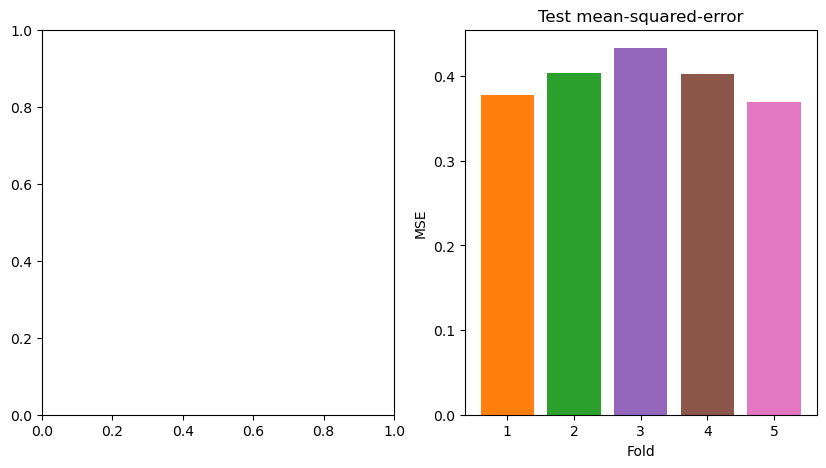

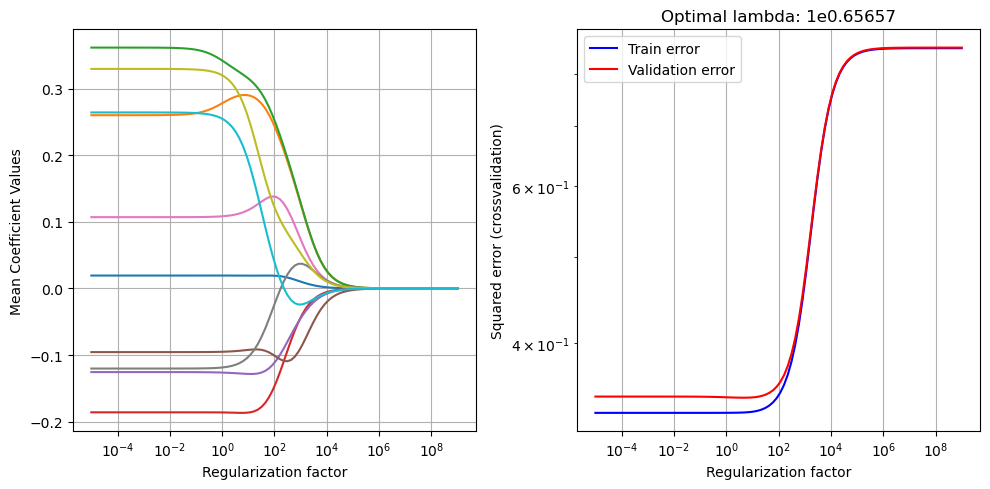

In [12]:
# Setup figure for display of ANN summaries
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10,5),num=2)
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

for k_out, (par_index, test_index) in enumerate(cv_outer.split(X,y)):
    
    print('\nOuter Cross Validation Fold: {0}/{1}'.format(k_out+1,K_outer))
    
    # Split outer fold into parameterisation set and test set
    X_par = X[par_index]
    y_par = y[par_index]
    X_test = X[test_index]
    y_test = y[test_index]
    y_par = y_par.squeeze()
    
    # Initialise error arrays
    w = np.empty((M,K_inner,len(lambdas)))           # 11 by 3 by 100
    train_error = np.empty((K_inner,len(lambdas)))   # 3 by 100
    val_error = np.empty((K_inner,len(lambdas)))     # 3 by 100
    test_error = np.empty((K_inner,len(lambdas)))    # 3 by 100
    
    ann_val_error = np.empty((K_inner,len(h_values)))   # 3 by 3
    ann_test_error = np.empty((K_inner,len(h_values)))  # 3 by 3
    
    # TODO: rename val_error, test_error, lambdas
    
    for k_in, (train_index, val_index) in enumerate(cv_inner.split(X_par,y_par)):
    
        print('\n\tInner Fold: {}/{}'.format(k_in+1,K_inner))
        
        # Split parameterisation set into training set and validation set
        X_train = X[train_index]
        y_train = y[train_index]
        X_val = X[val_index]
        y_val = y[val_index]
    
        ########################### Lingear Regression ###########################
        # Standardize inner fold based on training set, and save the mean and std
        mu[k_in, :] = np.mean(X_train[:, 1:], 0)
        sigma[k_in, :] = np.std(X_train[:, 1:], 0)
        X_train[:, 1:] = (X_train[:, 1:] - mu[k_in, :] ) / sigma[k_in, :]
        X_val[:, 1:] = (X_val[:, 1:] - mu[k_in, :] ) / sigma[k_in, :]

        # Precompute terms
        Xty = X_train.T @ y_train
        XtX = X_train.T @ X_train

        # solve for weights
        for l in range(0,len(lambdas)):
            # Compute parameters for current value of lambda and current CV fold
            lambdaI = lambdas[l] * np.eye(M)
            lambdaI[0,0] = 0 # remove bias regularization
            w[:,k_in,l] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
            
            # Evaluate training and validation performance
            train_error[k_in,l] = np.power(y_train-X_train @ w[:,k_in,l].T,2).mean(axis=0)
            val_error[k_in,l] = np.power(y_val-X_val @ w[:,k_in,l].T,2).mean(axis=0)
    
        ################################## ANN ##################################
        # Convert train and validation sets into tensors
        X_train = torch.Tensor(X[train_index,:])
        y_train = torch.Tensor(y[train_index]).reshape(-1,1)
        X_val = torch.Tensor(X[val_index,:])
        y_val = torch.Tensor(y[val_index]).reshape(-1,1)

        # Train the ANN using training dataset
        for h_enum, h in enumerate(h_values):
            net, best_final_loss, learning_curve = train_neural_net(model, 
                                                                   h,
                                                                   loss_fn,
                                                                   X=X_train,
                                                                   y=y_train,
                                                                   n_replicates=n_replicates,
                                                                   max_iter=max_iter)
            print('\n\tBest loss: {}\n'.format(best_final_loss))

            # Determine estimated values for validation set
            y_val_est = net(X_val)
            
            # Evaluate validation performance
            se_val = (y_val_est.squeeze().float()-y_val.squeeze().float())**2  # squared error
            mse_val = (sum(se_val).type(torch.float)/len(y_val)).data.numpy()      # mean squared error
            ann_val_error[k_in,h_enum] = mse_val


    ########################### Lingear Regression ###########################
    opt_val_err = np.min(np.mean(val_error,axis=0))        # get mean val_error for each lambda value, then find min
    opt_lambda = lambdas[np.argmin(np.mean(val_error,axis=0))]
    print("Optimal lambda found: ", round(np.log10(opt_lambda),5))   # TODO: check lambda value found at each outer fold
    train_err_vs_lambda = np.mean(train_error,axis=0)
    val_err_vs_lambda = np.mean(val_error,axis=0)
    mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))
    opt_lambdas[k_out] = opt_lambda              # Save optimal RLR hyperparameter from inner fold

    # Retrain linear regression model on parameterisation set using optimal lambda
    Xty_par = X_par.T @ y_par
    XtX_par = X_par.T @ X_par
    
    #### Estimate weights using parameterisation set
    # for the optimal value of lambda
    opt_lambda_I = opt_lambda * np.eye(M)
    opt_lambda_I[0,0] = 0 # remove bias regularization
    w_rlr[:,k_out] = np.linalg.solve(XtX_par+opt_lambda_I,Xty_par).squeeze()
    
    # for unregularized linear regression
    w_noreg[:,k_out] = np.linalg.solve(XtX_par,Xty_par).squeeze()
    
    #### Determine RLR test error 
    # MSE with regularization with optimal lambda
    Error_par_rlr[k_out] = np.square(y_par-X_par @ w_rlr[:,k_out]).sum(axis=0)/y_par.shape[0]
    Error_test_rlr[k_out] = np.square(y_test-X_test @ w_rlr[:,k_out]).sum(axis=0)/y_test.shape[0]
    
    # MSE without using the input data
    Error_par_nofeatures[k_out] = np.square(y_par-y_par.mean()).sum(axis=0)/y_par.shape[0]
    Error_test_nofeatures[k_out] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # MSE without regularization
    Error_par_lr[k_out] = np.square(y_par-X_par @ w_noreg[:,k_out]).sum(axis=0)/y_par.shape[0]
    Error_test_lr[k_out] = np.square(y_test-X_test @ w_noreg[:,k_out]).sum(axis=0)/y_test.shape[0]
    
    
    ##################################### ANN #####################################
    # Convert test set into tensors
    X_par = torch.Tensor(X[par_index])
    y_par = torch.Tensor(y[par_index]).reshape(-1,1)
    X_test = torch.Tensor(X[test_index])
    y_test = torch.Tensor(y[test_index]).reshape(-1,1)
    
    opt_ann_val_err = np.min(np.mean(ann_val_error,axis=0))
    opt_h = h_values[np.argmin(np.mean(ann_val_error,axis=0))]
    opt_h_values[k_out] = opt_h              # Save optimal ANN hyperparameter from inner fold
    
    # Retrain ANN on parameterisation set using optimal number of hidden units
    print("\tRetraining ANN using optimal number of hidden units")
    opt_net, final_loss, learning_curve = train_neural_net(model,
                                                           opt_h,
                                                           loss_fn,
                                                           X=X_par,
                                                           y=y_par,
                                                           n_replicates=n_replicates,
                                                           max_iter=max_iter)
    y_test_est = opt_net(X_test)
    
    # Determine ANN test error
    se_test = (y_test_est.squeeze().float()-y_test.squeeze().float())**2     # squared error
    mse_test = (sum(se_test).type(torch.float)/len(y_test)).data.numpy()
    Error_test_ANN[k_out] = mse_test                     # store error rate for current CV fold
    
    print("\n\tTest Error for Outer Fold {}/{}".format(k_out+1,K_outer))
    print("\n\t\tRLR: {}".format(np.round(mse_test,3)))
    print("\n\t\tANN: {:.5e}".format(Error_test_rlr[k_out][0]))
    
    
    ############################### DISPLAY RESULTS ###############################
    # Display the learning curve for the best net in the current outer fold
#     h, = summaries_axes[0].plot(learning_curve, color=color_list[k_out])
#     h.set_label('CV fold {0}'.format(k_out+1))
#     summaries_axes[0].set_xlabel('Iterations')
#     summaries_axes[0].set_ylabel('Loss')
#     summaries_axes[0].set_title('Learning curves')

   # Display the results for the last outer cross-validation fold
    if k_out == K_outer-1:
        reg_fig, reg_axes = plt.subplots(1, 2, figsize=(10,5),num=1)
        reg_axes[0].semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'-') # Don't plot the bias term
        reg_axes[0].set_xlabel('Regularization factor')
        reg_axes[0].set_ylabel('Mean Coefficient Values')
        reg_axes[0].grid()
        # TODO: add legend

        reg_axes[1].set_title('Optimal lambda: 1e{0}'.format(round(np.log10(opt_lambdas[k_out][0]),5)))
        reg_axes[1].loglog(lambdas,train_err_vs_lambda.T,'b-',lambdas,val_err_vs_lambda.T,'r-')
        reg_axes[1].set_xlabel('Regularization factor')
        reg_axes[1].set_ylabel('Squared error (crossvalidation)')
        reg_axes[1].legend(['Train error','Validation error'])
        reg_axes[1].grid()
        reg_fig.tight_layout()

# Display the MSE across folds
summaries_axes[1].bar(np.arange(1, K_outer+1), np.squeeze(np.asarray(Error_test_ANN)), color=color_list)
summaries_axes[1].set_xlabel('Fold')
summaries_axes[1].set_xticks(np.arange(1, K_outer+1))
summaries_axes[1].set_ylabel('MSE')
summaries_axes[1].set_title('Test mean-squared-error')

### Results of Linear Regression

In [13]:
print('Baseline without using the input data:')
print('- Test error:     {0}\n'.format(Error_test_nofeatures.mean()))

print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_par_lr.mean()))
print('- Test error:     {0}'.format(Error_test_lr.mean()))
print('- R^2 train:     {0}'.format((Error_par_nofeatures.sum()-Error_par_lr.sum())/Error_par_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_lr.sum())/Error_test_nofeatures.sum()))

print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_par_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_par_nofeatures.sum()-Error_par_rlr.sum())/Error_par_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

Baseline without using the input data:
- Test error:     0.9948369858259445

Linear regression without feature selection:
- Training error: 0.4405472230124016
- Test error:     0.4600678869322163
- R^2 train:     0.5593105068742019
- R^2 test:     0.5375444485005213

Regularized linear regression:
- Training error: 0.4479224084954775
- Test error:     0.45843600176969695
- R^2 train:     0.5519329396521883
- R^2 test:     0.5391848028357238



Text(0.5, 1.0, 'Weights from each fold of Regularized Linear Regression')

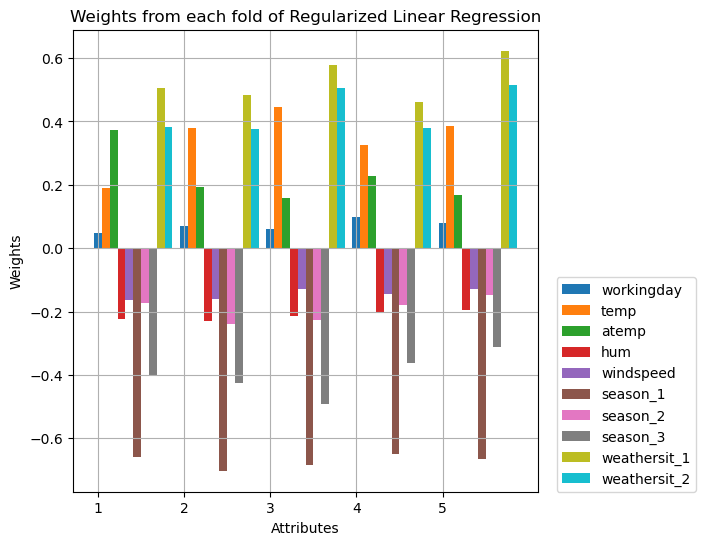

In [14]:
# Bar plot of RLR weights
weights = range(1,M)      # skip offset
bw = 1.0/(len(weights)+1)
r = np.arange(1,K_outer+1)

plt.figure(figsize=(6,6), num=3)
for i in weights:
    plt.bar(r+i*bw, w_rlr[i,:], width=bw)
plt.xticks(r+bw, range(1,K_outer+1))
plt.xlabel('Attributes')
plt.ylabel('Weights')
plt.legend(attribute_names[1:M+1], loc=(1.04, 0))
plt.grid()
plt.title('Weights from each fold of Regularized Linear Regression')

### Results of ANN

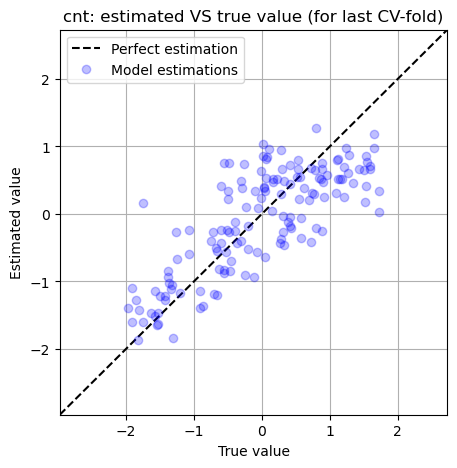

In [15]:
plt.figure(figsize=(5,5),num=5)
y_est = y_test_est.data.numpy().squeeze()
y_true = y_test.data.numpy().squeeze()
axis_range = [np.min([y_est, y_true])-1,np.max([y_est, y_true])+1]
plt.plot(axis_range,axis_range,'k--')           # perfect estimation
plt.plot(y_true, y_est,'ob',alpha=.25)          # ANN estimation
plt.legend(['Perfect estimation','Model estimations'])
plt.title('cnt: estimated VS true value (for last CV-fold)')
plt.ylim(axis_range)
plt.xlim(axis_range)
plt.xlabel('True value')
plt.ylabel('Estimated value')
plt.grid()

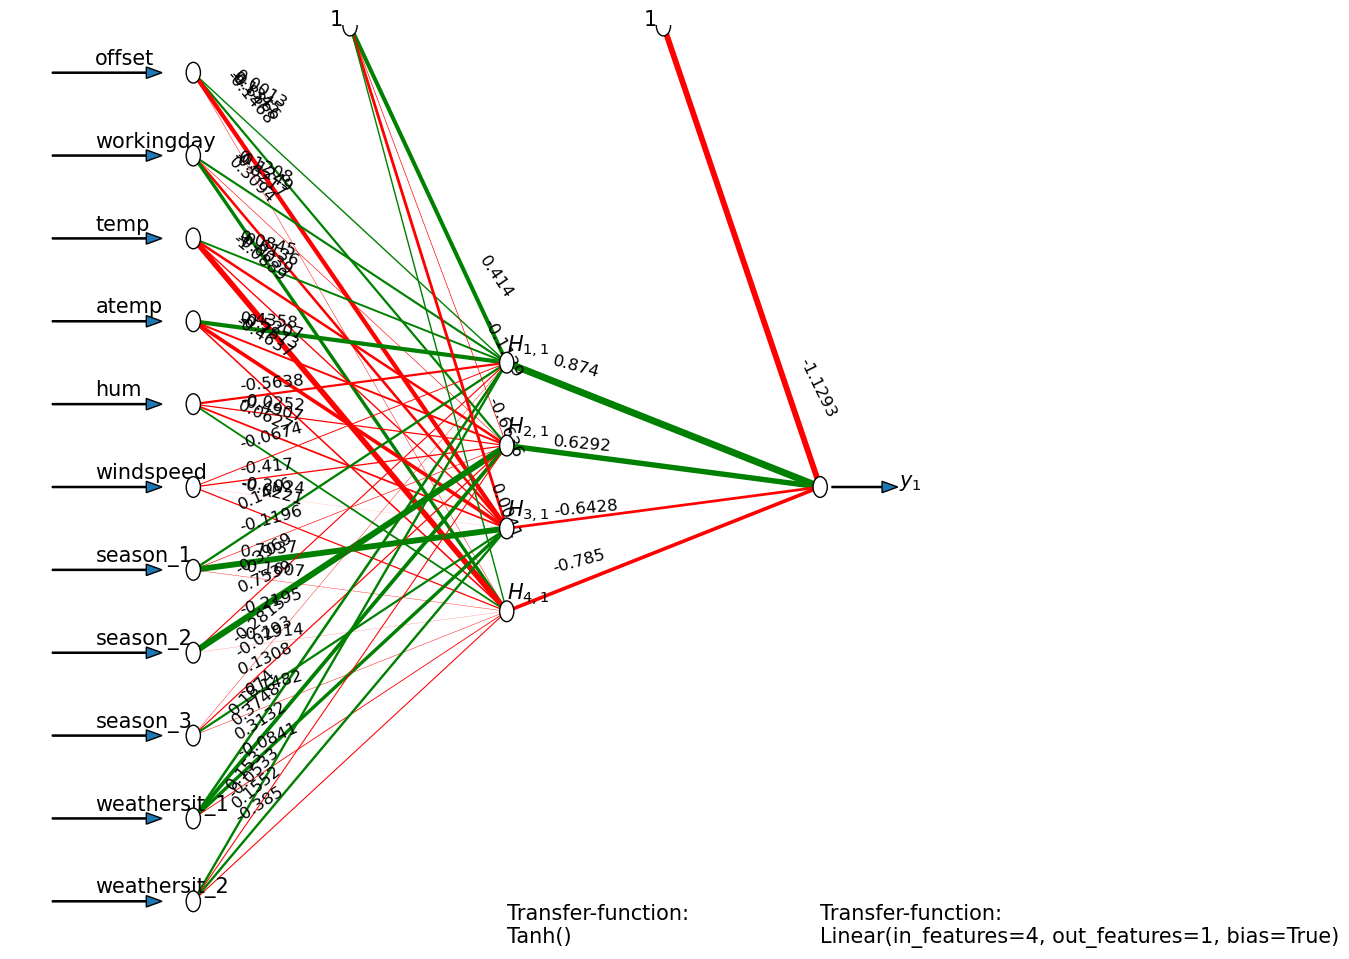

In [16]:
# Diagram of best neural net in last outer fold
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,2]]
draw_neural_net(weights, biases, tf, attribute_names=attribute_names)

plt.show()

### Table 2

In [17]:
print("Outer fold \tANN \t\t\tLinear Regression \t\tBaseline")
print("--------------------------------------------------------------------------------")
print("i \t\th_i \tEtest_i \tlambda_i \tEtest_i \tEtest_i")
for i in range(K_outer):
    print("{} \t\t{:.3f} \t{:.3f} \t\t1e{} \t{:.2f} \t\t{:.3f}".format(\
        i+1,opt_h_values[i][0],Error_test_ANN[i].item(),round(np.log10(opt_lambdas[i][0]),4),\
            Error_test_rlr[i][0],Error_test_nofeatures[i][0]))

Outer fold 	ANN 			Linear Regression 		Baseline
--------------------------------------------------------------------------------
i 		h_i 	Etest_i 	lambda_i 	Etest_i 	Etest_i
1 		4.000 	0.377 		1e0.798 	0.49 		1.023
2 		4.000 	0.403 		1e0.798 	0.43 		0.920
3 		3.000 	0.433 		1e0.6566 	0.51 		1.042
4 		4.000 	0.403 		1e1.0808 	0.46 		1.034
5 		4.000 	0.370 		1e0.6566 	0.40 		0.955


In [18]:
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:17:47


In [19]:
val_error.shape
opt_val_err = np.min(np.mean(val_error,axis=0))        # get mean val_error for each lambda value, then find min
opt_lambda = lambdas[np.argmin(np.mean(val_error,axis=0))]
opt_lambdas       # TODO: why are all lambdas the same? code error?

array([[ 6.28029144],
       [ 6.28029144],
       [ 4.53487851],
       [12.0450354 ],
       [ 4.53487851]])

In [20]:
Error_test_ANN

array([[0.37731281],
       [0.40318498],
       [0.43315315],
       [0.40298876],
       [0.36990145]])

## Saved Results Below